In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Cropping2D, Lambda, Activation, Dropout
from keras.optimizers import Adam
from keras.initializers import glorot_normal
from sklearn.utils import shuffle

from model import processFilename, Nvidia, generator

/home/freddy/apps/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
track = 'track2'

In [3]:
driving_log = pd.read_csv(
  '{}/driving_log.csv'.format(track), 
  names=['center','left','right','angle','throttle','brake','speed']
)

In [4]:
center_left_right_angle = driving_log[['center', 'left', 'right', 'angle']]

In [5]:
image = plt.imread( processFilename(track, center_left_right_angle.iloc[0].center) )

In [6]:
image.shape

(160, 320, 3)

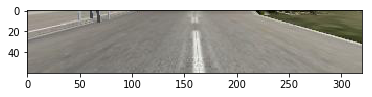

In [7]:
plt.imshow(image[75:-25,:,:])

In [8]:
image[75:-25,:,:].shape

(60, 320, 3)

In [9]:
# this function reads the images into memory, it is not a scalable approach when there are too many images
def read_angles(driving_log):
  angles = []
  for row in driving_log.itertuples():
    angle = row.angle
    angles.append(angle)
  # end for
  return np.array(angles)
# end def

In [10]:
angles = read_angles(center_left_right_angle)

In [11]:
angles.shape

(5107,)

In [12]:
augmented_angles = []
for angle in angles:
  augmented_angles.append(angle)
  augmented_angles.append(-angle)

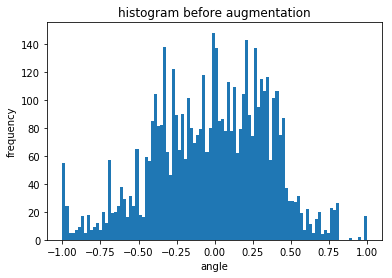

In [13]:
plt.hist(angles, bins=100)
plt.xlabel('angle')
plt.ylabel('frequency')
plt.title('histogram before augmentation')
plt.show()

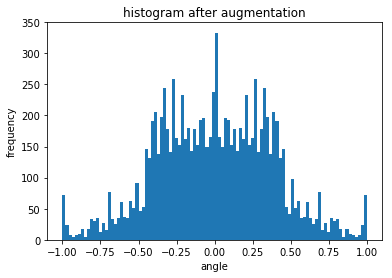

In [14]:
plt.hist(augmented_angles, bins=100)
plt.xlabel('angle')
plt.ylabel('frequency')
plt.title('histogram after augmentation')
plt.show()

In [16]:
np.random.seed(1) # set the random number seed

npts = len(center_left_right_angle)

# center_left_right_angle contains all the rows
# split into training and validation with a 0.8, 0.2 split

npts_rand = np.random.rand(npts)
train_set = center_left_right_angle[npts_rand <= 0.8]
valid_set = center_left_right_angle[npts_rand >  0.8]

In [17]:
batch_size = 50
train_generator = generator(train_set, batch_size, track)
valid_generator = generator(valid_set, batch_size, track)

steps_per_epoch  = np.rint(len(train_set) / batch_size).astype(int)
validation_steps = np.rint(len(valid_set) / batch_size).astype(int)

In [18]:
model = Nvidia(dropout=0.25)
optimizer = Adam(lr=1e-3)
model.compile(loss='mse', optimizer=optimizer)

In [19]:
model.fit_generator(
  train_generator, steps_per_epoch=steps_per_epoch, 
  epochs=10, 
  validation_data=valid_generator, validation_steps=validation_steps
)

Epoch 1/10
82/82 [==============================] - 54s 656ms/step - loss: 0.3079 - val_loss: 0.0798
Epoch 2/10
82/82 [==============================] - 49s 603ms/step - loss: 0.1205 - val_loss: 0.0733
Epoch 3/10
82/82 [==============================] - 49s 598ms/step - loss: 0.1086 - val_loss: 0.1478
Epoch 4/10
82/82 [==============================] - 49s 600ms/step - loss: 0.0869 - val_loss: 0.0708
Epoch 5/10
82/82 [==============================] - 49s 599ms/step - loss: 0.0765 - val_loss: 0.0521
Epoch 6/10
82/82 [==============================] - 49s 603ms/step - loss: 0.0674 - val_loss: 0.0437
Epoch 7/10
82/82 [==============================] - 49s 600ms/step - loss: 0.0682 - val_loss: 0.0426
Epoch 8/10
82/82 [==============================] - 49s 603ms/step - loss: 0.0615 - val_loss: 0.0471
Epoch 9/10
82/82 [==============================] - 49s 600ms/step - loss: 0.0589 - val_loss: 0.0385
Epoch 10/10
82/82 [==============================] - 49s 602ms/step - loss: 0.0559 - val_lo

In [ ]:
model.get_layer('conv5').output

In [ ]:
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('conv5').output)
intermediate_output = intermediate_layer_model.predict(np.expand_dims(image, 0))

In [ ]:
plt.imshow(intermediate_output[0,:,:,3],cmap='gray')

In [20]:
model.save('params/{}_model.h5'.format(track))